In [2]:
#import library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns  # visualization tool
from datetime import datetime
# plotly
import plotly 
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import warnings
#sns.set(font_scale=1.5)
warnings.filterwarnings("ignore")

In [3]:
deliveries = pd.read_csv('deliveries_updated_mens_ipl.csv')

In [4]:
df = deliveries.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243817 entries, 0 to 243816
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   matchId           243817 non-null  int64  
 1   inning            243817 non-null  int64  
 2   over_ball         243817 non-null  float64
 3   over              243817 non-null  int64  
 4   ball              243817 non-null  int64  
 5   batting_team      243817 non-null  object 
 6   bowling_team      243817 non-null  object 
 7   batsman           243817 non-null  object 
 8   non_striker       243817 non-null  object 
 9   bowler            243817 non-null  object 
 10  batsman_runs      243817 non-null  int64  
 11  extras            243817 non-null  int64  
 12  isWide            7652 non-null    float64
 13  isNoBall          1018 non-null    float64
 14  Byes              628 non-null     float64
 15  LegByes           3778 non-null    float64
 16  Penalty           2 

**Exploring the 'dismissal_kind'column**

In [6]:
df['dismissal_kind'].value_counts()

dismissal_kind
caught                   7437
bowled                   2089
run out                  1062
lbw                       750
caught and bowled         349
stumped                   345
retired hurt               15
hit wicket                 15
retired out                 3
obstructing the field       2
Name: count, dtype: int64

#### 'run out', 'retired hurt','retired out','obstructing the field'are not bowlers wicket.Hence we have to add a column 'isBowlersWkt' to see if the wicket was taken by the bowler.

In [7]:
def is_bowlers_wicket(player_dismissed,dismissal_kind):
    if type(player_dismissed)==str:
        if dismissal_kind not in ['run out','retired hurt','obstructing the field','retired out']:
            return 1
        else:
            return 0
    else:
        return 0

In [8]:
df['isBowlersWkt'] = df.apply(lambda x: is_bowlers_wicket(x['player_dismissed'], x['dismissal_kind']), axis=1)

In [9]:
df.columns

Index(['matchId', 'inning', 'over_ball', 'over', 'ball', 'batting_team',
       'bowling_team', 'batsman', 'non_striker', 'bowler', 'batsman_runs',
       'extras', 'isWide', 'isNoBall', 'Byes', 'LegByes', 'Penalty',
       'dismissal_kind', 'player_dismissed', 'date', 'isBowlersWkt'],
      dtype='object')

### now we have 'isBowlersWkt' as an column in our dataframe.

In [10]:
# Save the 'new_deliveries' DataFrame to a new CSV file
df.to_csv('E:\deliveries_rcb_ipl.csv', index=False)

In [11]:
#We will be working with the copied data for further analysis 
df_copy =df.copy()

## **RCB Bowling Analysis**
#### RCB Bowlers including Allrounders: 
Vyshak Vijay Kumar, Mohammed Siraj,Karn Sharma,Akash Deep,Glenn Maxwell,Mahipal Lomror,Himanshu Sharma,Manoj Bhandage,Rajan Kumar,Will Jacks,Mayank Dagar,Reece Topley,Cameron Green,Alzarri Joseph,Yash Dayal,Tom Curran,Lockie Ferguson.

#### Lets try to find the names of these bowlers and the all rounders in the datasheet. We will be doing a closest match of the names.

In [11]:
# List of names to search for in the uploaded datasheet
names_to_search = [
    "Vyshak Vijay Kumar", "Mohammed Siraj", "Karn Sharma", "Akash Deep", "Glenn Maxwell",
    "Mahipal Lomror", "Himanshu Sharma", "Manoj Bhandage", "Rajan Kumar", "Will Jacks",
    "Mayank Dagar", "Reece Topley", "Cameron Green", "Alzarri Joseph", "Yash Dayal",
    "Tom Curran", "Lockie Ferguson"
]

# Extracting the list of unique bowler names from the dataset
unique_bowler_names = df_copy['bowler'].unique().tolist()

# Checking for close matches for each name in the list against the dataset's bowler names
from difflib import get_close_matches

# Dictionary to hold the closest match found for each name
closest_matches = {}

# Searching for the closest match in the bowler names for each name in the list
for name in names_to_search:
    # Using get_close_matches to find the closest match with a cutoff for similarity to consider a match
    match = get_close_matches(name, unique_bowler_names, n=1, cutoff=0.4)  # Adjust cutoff as needed
    if match:
        closest_matches[name] = match[0]
    else:
        closest_matches[name] = "No close match found"

closest_matches

{'Vyshak Vijay Kumar': 'R Vinay Kumar',
 'Mohammed Siraj': 'Mohammed Siraj',
 'Karn Sharma': 'KV Sharma',
 'Akash Deep': 'Akash Deep',
 'Glenn Maxwell': 'GJ Maxwell',
 'Mahipal Lomror': 'MK Lomror',
 'Himanshu Sharma': 'Suyash Sharma',
 'Manoj Bhandage': 'SM Boland',
 'Rajan Kumar': 'R Vinay Kumar',
 'Will Jacks': 'KS Williamson',
 'Mayank Dagar': 'Mayank Dagar',
 'Reece Topley': 'RJW Topley',
 'Cameron Green': 'C Green',
 'Alzarri Joseph': 'AS Joseph',
 'Yash Dayal': 'Yash Dayal',
 'Tom Curran': 'TK Curran',
 'Lockie Ferguson': 'LH Ferguson'}

### We have not found the match for Himanshu Sharma, Manoj Bhandage,Rajan Kumar,Will Jacks in the given dataset.Hence we will be doing the bowling analysis for the below:
### R Vinay Kumar, Mohammad Siraj, KV Sharma , Akash Deep, GJ Maxwell, MK Lomror, Mayank Dagar, RJW Topley, C Green, AS Joseph, Yash Dayal, TK Curran, LH  Ferguson

In [12]:
# Filtering to ensure we only include the bowlers actually present in the analysis
bowlers_to_analyze = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

filtered_bowlers = [bowler for bowler in bowlers_to_analyze if bowler in unique_bowler_names]

# Step 1: Calculate total runs conceded by each bowler
# Note: Total runs conceded for a delivery = 'batsman_runs' + 'extras' - 'Byes' - 'LegByes'
# Replace NaN values with 0 for calculation

df_copy['Byes'] = df_copy['Byes'].fillna(0)
df_copy['LegByes'] = df_copy['LegByes'].fillna(0)
df_copy['Total_Runs_Conceded'] = df_copy['batsman_runs'] + df_copy['extras'] - df_copy['Byes'] - df_copy['LegByes']

# Recalculating the metrics for the corrected list of bowlers
bowling_analysis = df_copy[df_copy['bowler'].isin(filtered_bowlers)].groupby('bowler').agg(
    Matches_Played=pd.NamedAgg(column='matchId', aggfunc=pd.Series.nunique),
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count'),
    Total_Runs_Conceded=pd.NamedAgg(column='Total_Runs_Conceded', aggfunc='sum')
)

# Calculating Bowling Economy Rate
bowling_analysis['Bowling_Economy_Rate'] = (bowling_analysis['Total_Runs_Conceded'] / bowling_analysis['Balls_Bowled']) * 6

bowling_analysis

,Matches_Played,Balls_Bowled,Total_Runs_Conceded,Bowling_Economy_Rate
bowler,,,,
AS Joseph,19,390,576.0,8.861538
Akash Deep,7,152,264.0,10.421053
C Green,16,239,361.0,9.062762
GJ Maxwell,73,867,1174.0,8.124567
KV Sharma,73,1371,1833.0,8.021882
LH Ferguson,38,855,1173.0,8.231579
MK Lomror,10,85,109.0,7.694118
Mayank Dagar,3,66,83.0,7.545455
R Vinay Kumar,104,2186,2986.0,8.195791


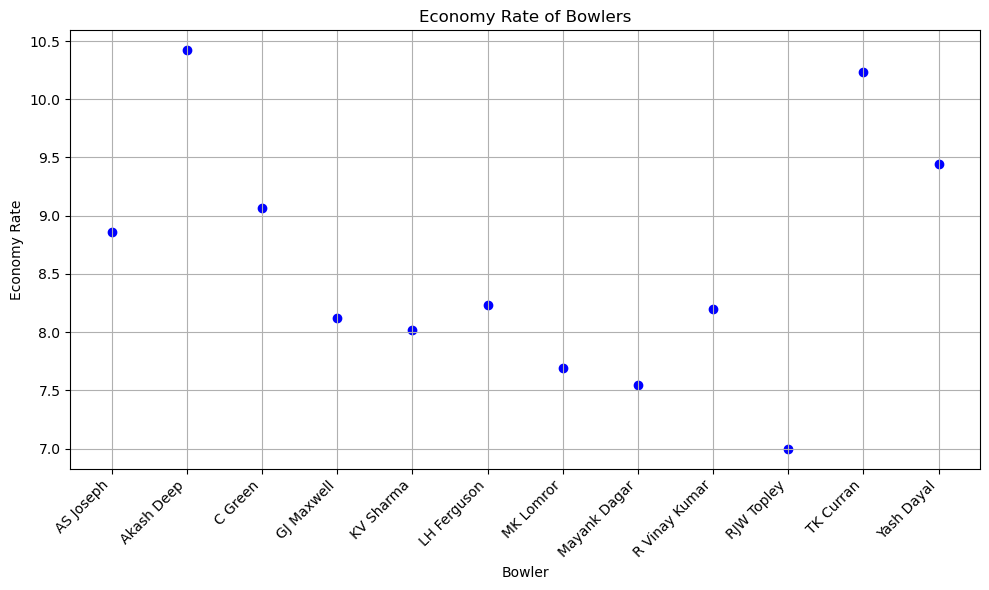

In [13]:

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(bowling_analysis.index, bowling_analysis['Bowling_Economy_Rate'], color='blue')
plt.title('Economy Rate of Bowlers')
plt.xlabel('Bowler')
plt.ylabel('Economy Rate')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Defining the list of bowlers to analyze for wickets taken
bowlers_to_analyze_wickets = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

# Filtering the dataset for these bowlers and adjusting for any differences in bowler names
wickets_analysis_final = df_copy[df_copy['bowler'].isin(bowlers_to_analyze_wickets)].groupby('bowler').agg(
    Matches_Played=pd.NamedAgg(column='matchId', aggfunc=pd.Series.nunique),
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count'),
    Wickets_Taken=pd.NamedAgg(column='isBowlersWkt', aggfunc='sum')
).assign(
    Strike_Rate=lambda x: x['Balls_Bowled'] / x['Wickets_Taken']
)

# Displaying the final analysis
wickets_analysis_final


,Matches_Played,Balls_Bowled,Wickets_Taken,Strike_Rate
bowler,,,,
AS Joseph,19,390,20,19.500000
Akash Deep,7,152,6,25.333333
C Green,16,239,6,39.833333
GJ Maxwell,73,867,31,27.967742
KV Sharma,73,1371,69,19.869565
LH Ferguson,38,855,39,21.923077
MK Lomror,10,85,1,85.000000
Mayank Dagar,3,66,1,66.000000
R Vinay Kumar,104,2186,105,20.819048


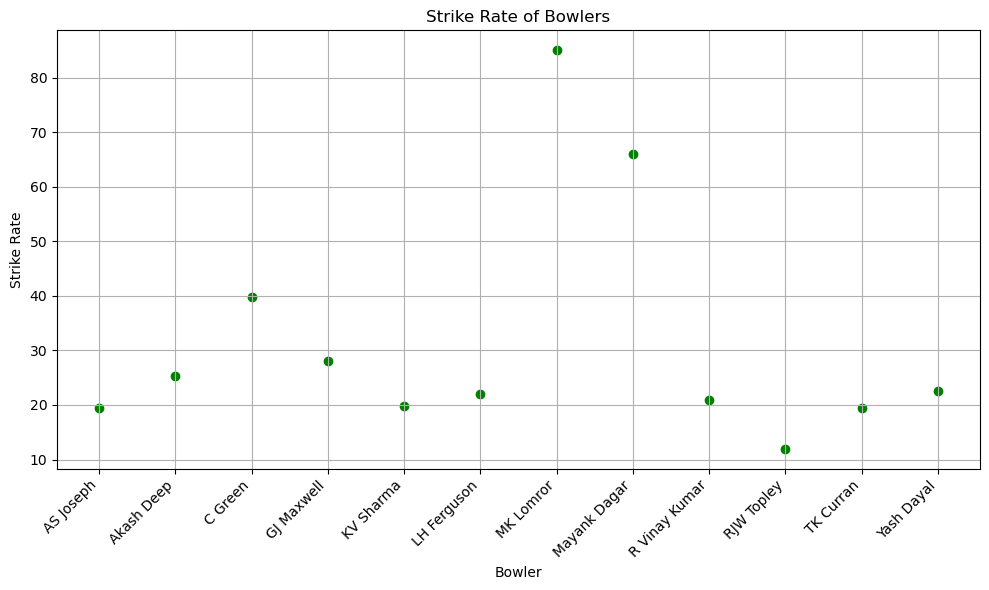

In [15]:
# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(wickets_analysis_final.index, wickets_analysis_final['Strike_Rate'], color='green')
plt.title('Strike Rate of Bowlers')
plt.xlabel('Bowler')
plt.ylabel('Strike Rate')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# Defining the list of bowlers to analyze for wickets taken
bowlers_to_analyze_wickets = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

# Filtering the dataset for these bowlers
df_wickets = df_copy[df_copy['bowler'].isin(bowlers_to_analyze_wickets)]

# Grouping by bowler and dismissal_kind to count wickets for each type
dismissal_counts = df_wickets[df_wickets['isBowlersWkt'] == 1].groupby(['bowler', 'dismissal_kind']).size().unstack(fill_value=0)

# Adding a total column for each bowler
dismissal_counts['Total'] = dismissal_counts.sum(axis=1)

dismissal_counts


dismissal_kind,bowled,caught,caught and bowled,lbw,stumped,Total
bowler,,,,,,
AS Joseph,6,13,1,0,0,20
Akash Deep,1,4,1,0,0,6
C Green,1,5,0,0,0,6
GJ Maxwell,9,17,0,4,1,31
KV Sharma,8,48,2,6,5,69
LH Ferguson,8,29,0,2,0,39
MK Lomror,0,0,0,0,1,1
Mayank Dagar,0,1,0,0,0,1
R Vinay Kumar,13,82,4,6,0,105


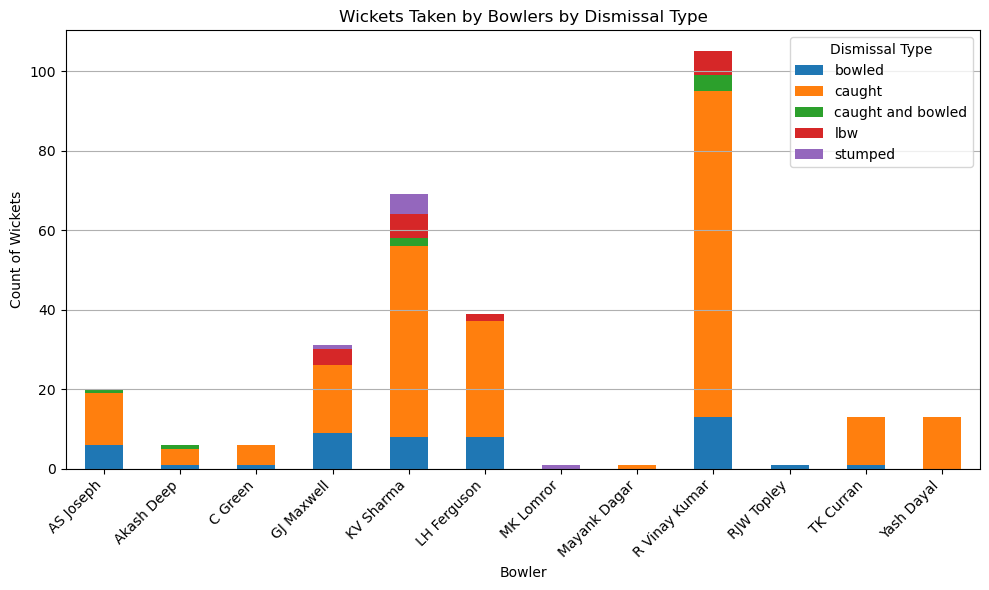

In [17]:
# Removing the 'Total' column from dismissal_counts DataFrame
dismissal_counts_without_total = dismissal_counts.drop(columns=['Total'])

# Plotting the stacked bar chart
dismissal_counts_without_total.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Wickets Taken by Bowlers by Dismissal Type')
plt.xlabel('Bowler')
plt.ylabel('Count of Wickets')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Dismissal Type')
plt.grid(axis='y')  # Add gridlines for y-axis

plt.tight_layout()
plt.show()


## **Power Play Analysis**

In [18]:
# Defining the list of bowlers to analyze
bowlers_to_analyze = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

# Filter the dataset for the specified bowlers and deliveries in the Power Play (overs 0-6)
powerplay_deliveries = df_copy[(df_copy['bowler'].isin(bowlers_to_analyze)) & (df_copy['over'].isin(range(7)))]

# Calculate the total runs conceded and balls bowled during the Power Play for each bowler
powerplay_metrics = powerplay_deliveries.groupby('bowler').agg(
    Total_Runs_Conceded=pd.NamedAgg(column='batsman_runs', aggfunc='sum'),
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count')
)

# Calculate the economy rate during the Power Play
powerplay_metrics['Economy_Rate'] = (powerplay_metrics['Total_Runs_Conceded'] / powerplay_metrics['Balls_Bowled']) * 6

# Display the economy rate of the players in the Power Play
powerplay_metrics[['Economy_Rate']]


,Economy_Rate
bowler,
AS Joseph,8.727273
Akash Deep,8.631579
C Green,7.408163
GJ Maxwell,7.778656
KV Sharma,6.394464
LH Ferguson,7.288732
MK Lomror,7.250000
Mayank Dagar,11.000000
R Vinay Kumar,6.876106


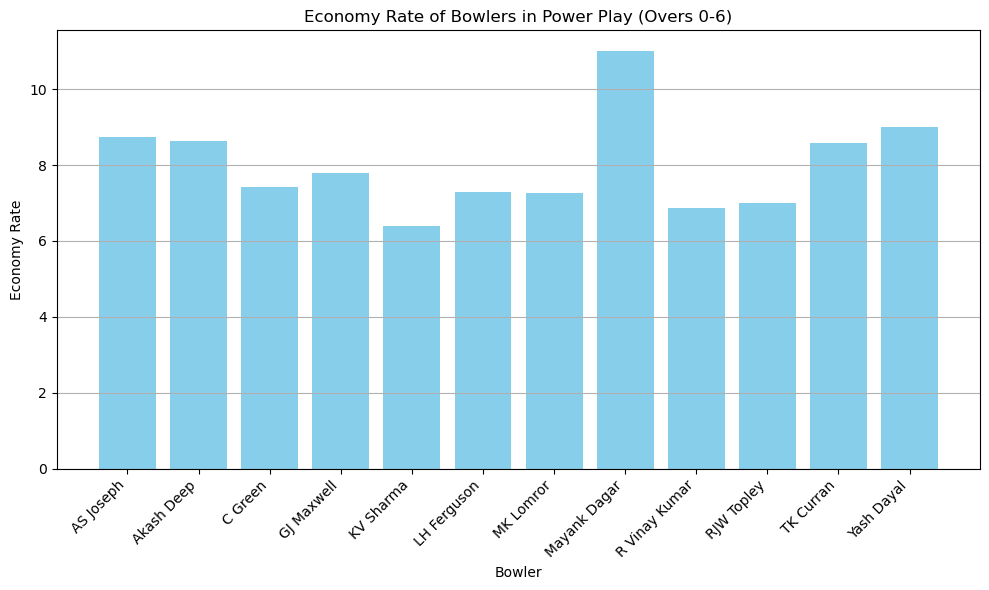

In [19]:
# Plotting the economy rate of players in the Power Play
plt.figure(figsize=(10, 6))
plt.bar(powerplay_metrics.index, powerplay_metrics['Economy_Rate'], color='skyblue')
plt.title('Economy Rate of Bowlers in Power Play (Overs 0-6)')
plt.xlabel('Bowler')
plt.ylabel('Economy Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## **Performance of Pace Bowlers and Spin Bowlers during the Power Play**

In [20]:
# Define the list of bowlers and their categorization
bowlers_to_analyze = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

spin_bowlers = ["GJ Maxwell", "MK Lomror", "Mayank Dagar", "KV Sharma"]
pace_bowlers = [bowler for bowler in bowlers_to_analyze if bowler not in spin_bowlers]

# Filter the dataset for the Power Play (overs 0-6) deliveries
powerplay_deliveries = df_copy[(df_copy['bowler'].isin(bowlers_to_analyze)) & (df_copy['over'].isin(range(7)))]

# Filter the dataset for spin bowlers and calculate their economy rate
spin_bowler_deliveries = powerplay_deliveries[powerplay_deliveries['bowler'].isin(spin_bowlers)]
spin_bowler_economy_rate = (spin_bowler_deliveries.groupby('bowler').sum()['batsman_runs'] / spin_bowler_deliveries.groupby('bowler').count()['over_ball']) * 6

# Filter the dataset for pace bowlers and calculate their economy rate
pace_bowler_deliveries = powerplay_deliveries[powerplay_deliveries['bowler'].isin(pace_bowlers)]
pace_bowler_economy_rate = (pace_bowler_deliveries.groupby('bowler').sum()['batsman_runs'] / pace_bowler_deliveries.groupby('bowler').count()['over_ball']) * 6

# Display the economy rate of spin and pace bowlers in the Power Play
spin_bowler_economy_rate, pace_bowler_economy_rate


(bowler
 GJ Maxwell       7.778656
 KV Sharma        6.394464
 MK Lomror        7.250000
 Mayank Dagar    11.000000
 dtype: float64,
 bowler
 AS Joseph        8.727273
 Akash Deep       8.631579
 C Green          7.408163
 LH Ferguson      7.288732
 R Vinay Kumar    6.876106
 RJW Topley       7.000000
 TK Curran        8.590909
 Yash Dayal       9.000000
 dtype: float64)

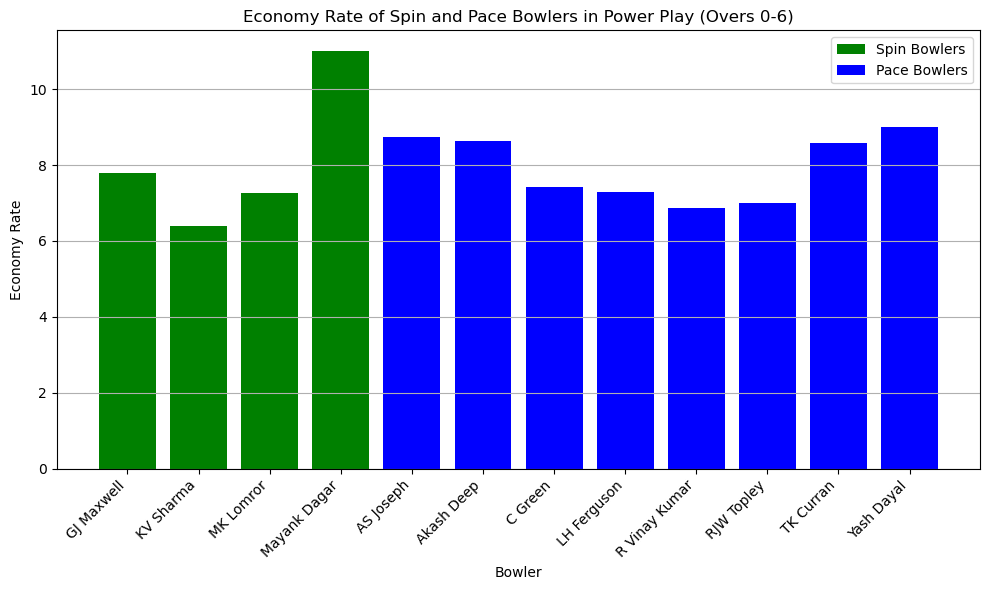

In [21]:
import matplotlib.pyplot as plt

# Define the list of bowlers and their categorization
bowlers_to_analyze = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

spin_bowlers = ["GJ Maxwell", "MK Lomror", "Mayank Dagar", "KV Sharma"]
pace_bowlers = [bowler for bowler in bowlers_to_analyze if bowler not in spin_bowlers]

# Filter the dataset for the Power Play (overs 0-6) deliveries
powerplay_deliveries = df_copy[(df_copy['bowler'].isin(bowlers_to_analyze)) & (df_copy['over'].isin(range(7)))]

# Filter the dataset for spin bowlers and calculate their economy rate
spin_bowler_deliveries = powerplay_deliveries[powerplay_deliveries['bowler'].isin(spin_bowlers)]
spin_bowler_economy_rate = (spin_bowler_deliveries.groupby('bowler').sum()['batsman_runs'] / spin_bowler_deliveries.groupby('bowler').count()['over_ball']) * 6

# Filter the dataset for pace bowlers and calculate their economy rate
pace_bowler_deliveries = powerplay_deliveries[powerplay_deliveries['bowler'].isin(pace_bowlers)]
pace_bowler_economy_rate = (pace_bowler_deliveries.groupby('bowler').sum()['batsman_runs'] / pace_bowler_deliveries.groupby('bowler').count()['over_ball']) * 6

# Plotting the economy rate of spin and pace bowlers
plt.figure(figsize=(10, 6))
plt.bar(spin_bowler_economy_rate.index, spin_bowler_economy_rate.values, color='green', label='Spin Bowlers')
plt.bar(pace_bowler_economy_rate.index, pace_bowler_economy_rate.values, color='blue', label='Pace Bowlers')
plt.title('Economy Rate of Spin and Pace Bowlers in Power Play (Overs 0-6)')
plt.xlabel('Bowler')
plt.ylabel('Economy Rate')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()


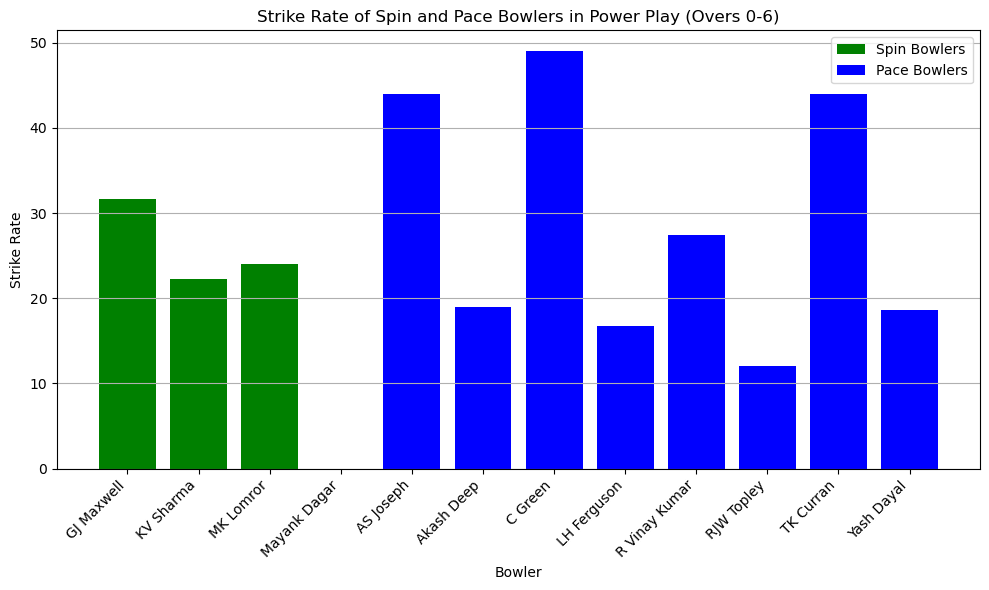

In [22]:
# Filter the dataset for spin bowlers and calculate their strike rate
spin_bowler_deliveries = powerplay_deliveries[powerplay_deliveries['bowler'].isin(spin_bowlers)]
spin_bowler_strike_rate = spin_bowler_deliveries.groupby('bowler').agg(
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count'),
    Wickets_Taken=pd.NamedAgg(column='isBowlersWkt', aggfunc='sum')
)
spin_bowler_strike_rate['Strike_Rate'] = spin_bowler_strike_rate['Balls_Bowled'] / spin_bowler_strike_rate['Wickets_Taken']

# Filter the dataset for pace bowlers and calculate their strike rate
pace_bowler_deliveries = powerplay_deliveries[powerplay_deliveries['bowler'].isin(pace_bowlers)]
pace_bowler_strike_rate = pace_bowler_deliveries.groupby('bowler').agg(
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count'),
    Wickets_Taken=pd.NamedAgg(column='isBowlersWkt', aggfunc='sum')
)
pace_bowler_strike_rate['Strike_Rate'] = pace_bowler_strike_rate['Balls_Bowled'] / pace_bowler_strike_rate['Wickets_Taken']

# Plotting the strike rate of spin and pace bowlers
plt.figure(figsize=(10, 6))
plt.bar(spin_bowler_strike_rate.index, spin_bowler_strike_rate['Strike_Rate'], color='green', label='Spin Bowlers')
plt.bar(pace_bowler_strike_rate.index, pace_bowler_strike_rate['Strike_Rate'], color='blue', label='Pace Bowlers')
plt.title('Strike Rate of Spin and Pace Bowlers in Power Play (Overs 0-6)')
plt.xlabel('Bowler')
plt.ylabel('Strike Rate')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## **Performance of Pace Bowlers and Spin Bowlers during the Middle Overs**

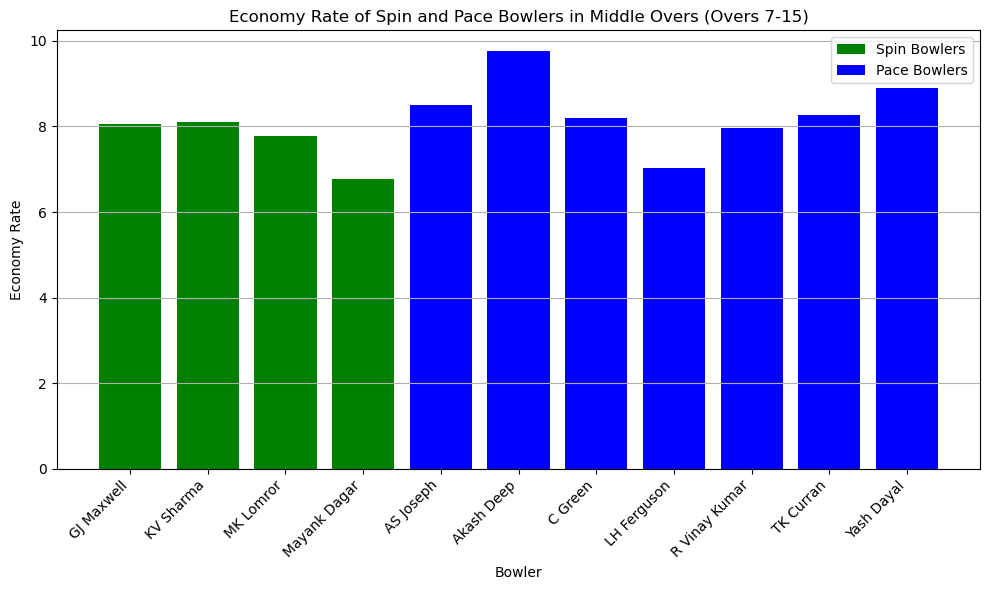

In [23]:
# Filter the dataset for Middle Overs (overs 7-15) deliveries
middle_overs_deliveries = df_copy[(df_copy['bowler'].isin(bowlers_to_analyze)) & (df_copy['over'].isin(range(7, 16)))]

# Filter the dataset for spin bowlers and calculate their economy rate
spin_bowler_middle_overs = middle_overs_deliveries[middle_overs_deliveries['bowler'].isin(spin_bowlers)]
spin_bowler_economy_rate_middle = spin_bowler_middle_overs.groupby('bowler').agg(
    Total_Runs_Conceded=pd.NamedAgg(column='batsman_runs', aggfunc='sum'),
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count')
)
spin_bowler_economy_rate_middle['Economy_Rate'] = (spin_bowler_economy_rate_middle['Total_Runs_Conceded'] / spin_bowler_economy_rate_middle['Balls_Bowled']) * 6

# Filter the dataset for pace bowlers and calculate their economy rate
pace_bowler_middle_overs = middle_overs_deliveries[middle_overs_deliveries['bowler'].isin(pace_bowlers)]
pace_bowler_economy_rate_middle = pace_bowler_middle_overs.groupby('bowler').agg(
    Total_Runs_Conceded=pd.NamedAgg(column='batsman_runs', aggfunc='sum'),
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count')
)
pace_bowler_economy_rate_middle['Economy_Rate'] = (pace_bowler_economy_rate_middle['Total_Runs_Conceded'] / pace_bowler_economy_rate_middle['Balls_Bowled']) * 6

# Plotting the economy rate of spin and pace bowlers in Middle Overs
plt.figure(figsize=(10, 6))
plt.bar(spin_bowler_economy_rate_middle.index, spin_bowler_economy_rate_middle['Economy_Rate'], color='green', label='Spin Bowlers')
plt.bar(pace_bowler_economy_rate_middle.index, pace_bowler_economy_rate_middle['Economy_Rate'], color='blue', label='Pace Bowlers')
plt.title('Economy Rate of Spin and Pace Bowlers in Middle Overs (Overs 7-15)')
plt.xlabel('Bowler')
plt.ylabel('Economy Rate')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()


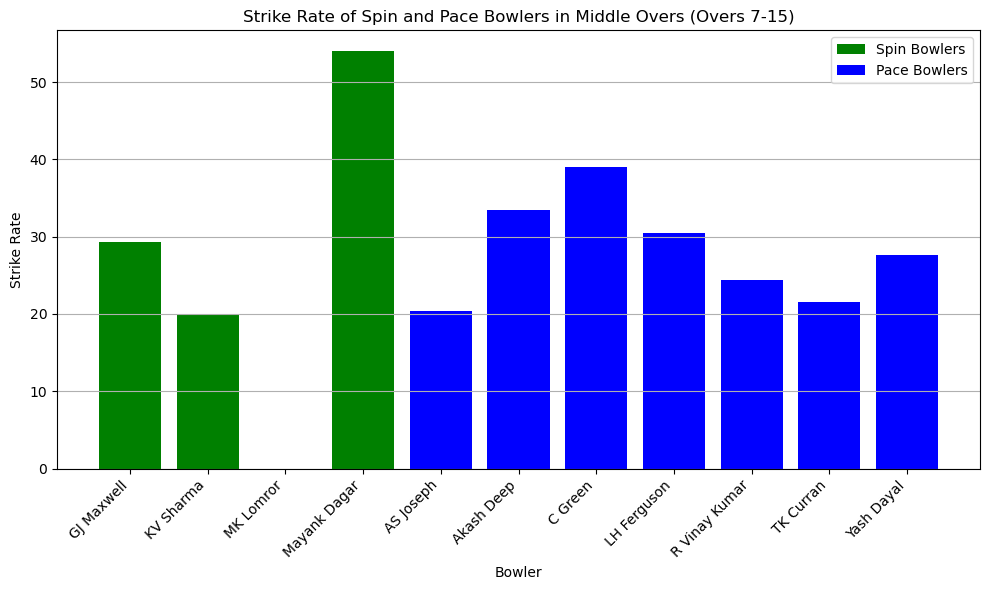

In [24]:
# Filter the dataset for spin bowlers and calculate their strike rate
spin_bowler_deliveries = middle_overs_deliveries[middle_overs_deliveries['bowler'].isin(spin_bowlers)]
spin_bowler_strike_rate = spin_bowler_deliveries.groupby('bowler').agg(
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count'),
    Wickets_Taken=pd.NamedAgg(column='isBowlersWkt', aggfunc='sum')
)
spin_bowler_strike_rate['Strike_Rate'] = spin_bowler_strike_rate['Balls_Bowled'] / spin_bowler_strike_rate['Wickets_Taken']

# Filter the dataset for pace bowlers and calculate their strike rate
pace_bowler_deliveries = middle_overs_deliveries[middle_overs_deliveries['bowler'].isin(pace_bowlers)]
pace_bowler_strike_rate = pace_bowler_deliveries.groupby('bowler').agg(
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count'),
    Wickets_Taken=pd.NamedAgg(column='isBowlersWkt', aggfunc='sum')
)
pace_bowler_strike_rate['Strike_Rate'] = pace_bowler_strike_rate['Balls_Bowled'] / pace_bowler_strike_rate['Wickets_Taken']

# Plotting the strike rate of spin and pace bowlers
plt.figure(figsize=(10, 6))
plt.bar(spin_bowler_strike_rate.index, spin_bowler_strike_rate['Strike_Rate'], color='green', label='Spin Bowlers')
plt.bar(pace_bowler_strike_rate.index, pace_bowler_strike_rate['Strike_Rate'], color='blue', label='Pace Bowlers')
plt.title('Strike Rate of Spin and Pace Bowlers in Middle Overs (Overs 7-15)')
plt.xlabel('Bowler')
plt.ylabel('Strike Rate')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## **Performance of Pace Bowlers and Spin Bowlers during the Death Overs**

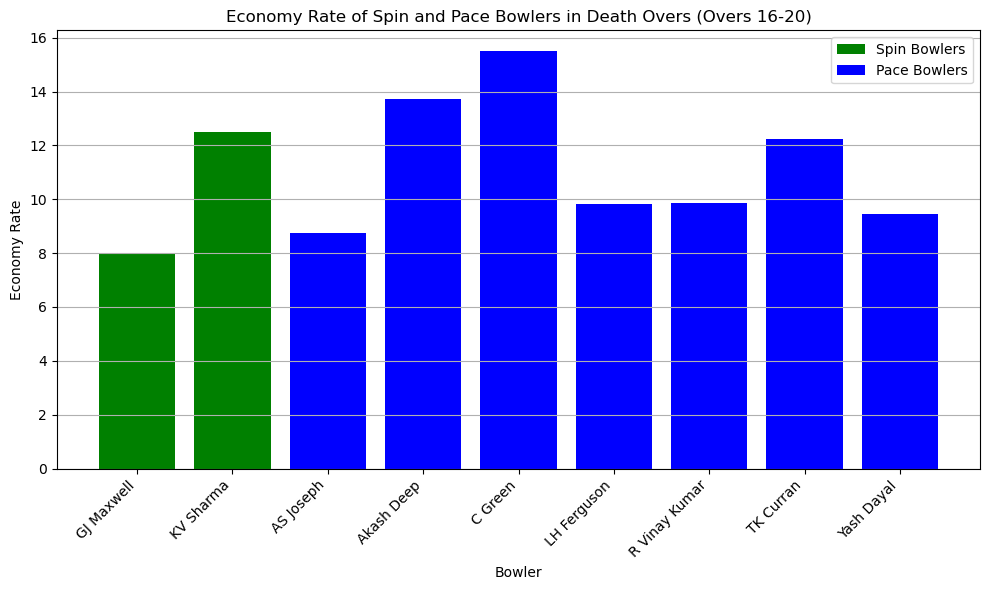

In [25]:
# Filter the dataset for Middle Overs (overs 16-20) deliveries
death_overs_deliveries = df_copy[(df_copy['bowler'].isin(bowlers_to_analyze)) & (df_copy['over'].isin(range(16, 20)))]

# Filter the dataset for spin bowlers and calculate their economy rate
spin_bowler_death_overs = death_overs_deliveries[death_overs_deliveries['bowler'].isin(spin_bowlers)]
spin_bowler_economy_rate_death = spin_bowler_death_overs.groupby('bowler').agg(
    Total_Runs_Conceded=pd.NamedAgg(column='batsman_runs', aggfunc='sum'),
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count')
)
spin_bowler_economy_rate_death['Economy_Rate'] = (spin_bowler_economy_rate_death['Total_Runs_Conceded'] / spin_bowler_economy_rate_death['Balls_Bowled']) * 6

# Filter the dataset for pace bowlers and calculate their economy rate
pace_bowler_death_overs = death_overs_deliveries[death_overs_deliveries['bowler'].isin(pace_bowlers)]
pace_bowler_economy_rate_death = pace_bowler_death_overs.groupby('bowler').agg(
    Total_Runs_Conceded=pd.NamedAgg(column='batsman_runs', aggfunc='sum'),
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count')
)
pace_bowler_economy_rate_death['Economy_Rate'] = (pace_bowler_economy_rate_death['Total_Runs_Conceded'] / pace_bowler_economy_rate_death['Balls_Bowled']) * 6

# Plotting the economy rate of spin and pace bowlers in Middle Overs
plt.figure(figsize=(10, 6))
plt.bar(spin_bowler_economy_rate_death.index, spin_bowler_economy_rate_death['Economy_Rate'], color='green', label='Spin Bowlers')
plt.bar(pace_bowler_economy_rate_death.index, pace_bowler_economy_rate_death['Economy_Rate'], color='blue', label='Pace Bowlers')
plt.title('Economy Rate of Spin and Pace Bowlers in Death Overs (Overs 16-20)')
plt.xlabel('Bowler')
plt.ylabel('Economy Rate')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

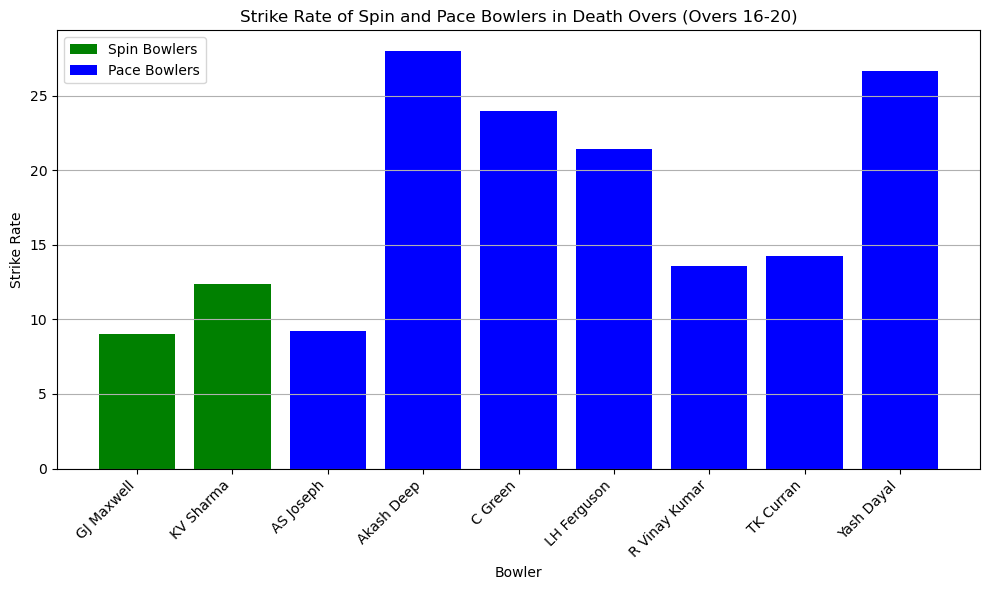

In [26]:
# Filter the dataset for spin bowlers and calculate their strike rate
spin_bowler_deliveries = death_overs_deliveries[death_overs_deliveries['bowler'].isin(spin_bowlers)]
spin_bowler_strike_rate = spin_bowler_deliveries.groupby('bowler').agg(
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count'),
    Wickets_Taken=pd.NamedAgg(column='isBowlersWkt', aggfunc='sum')
)
spin_bowler_strike_rate['Strike_Rate'] = spin_bowler_strike_rate['Balls_Bowled'] / spin_bowler_strike_rate['Wickets_Taken']

# Filter the dataset for pace bowlers and calculate their strike rate
pace_bowler_deliveries = death_overs_deliveries[death_overs_deliveries['bowler'].isin(pace_bowlers)]
pace_bowler_strike_rate = pace_bowler_deliveries.groupby('bowler').agg(
    Balls_Bowled=pd.NamedAgg(column='over_ball', aggfunc='count'),
    Wickets_Taken=pd.NamedAgg(column='isBowlersWkt', aggfunc='sum')
)
pace_bowler_strike_rate['Strike_Rate'] = pace_bowler_strike_rate['Balls_Bowled'] / pace_bowler_strike_rate['Wickets_Taken']

# Plotting the strike rate of spin and pace bowlers
plt.figure(figsize=(10, 6))
plt.bar(spin_bowler_strike_rate.index, spin_bowler_strike_rate['Strike_Rate'], color='green', label='Spin Bowlers')
plt.bar(pace_bowler_strike_rate.index, pace_bowler_strike_rate['Strike_Rate'], color='blue', label='Pace Bowlers')
plt.title('Strike Rate of Spin and Pace Bowlers in Death Overs (Overs 16-20)')
plt.xlabel('Bowler')
plt.ylabel('Strike Rate')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

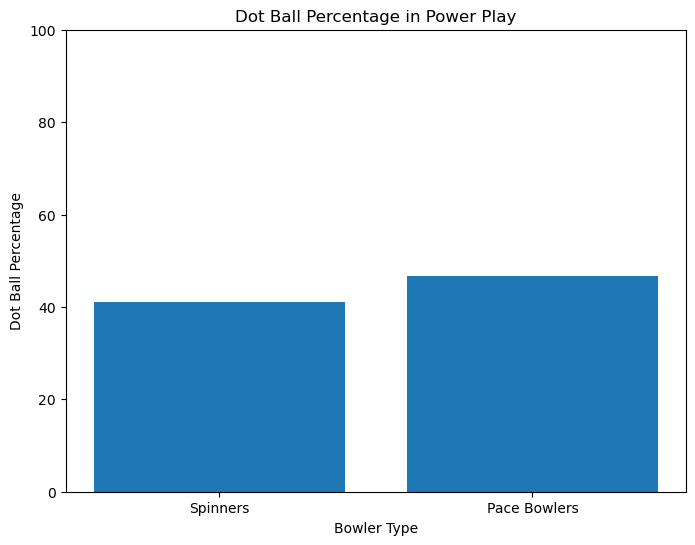

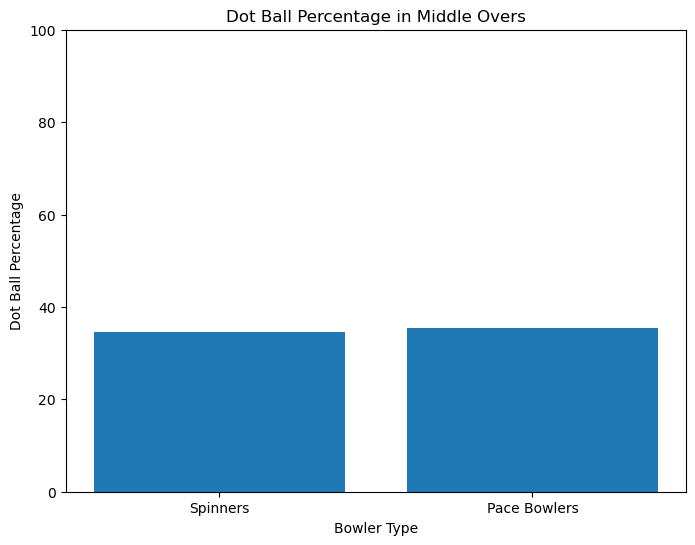

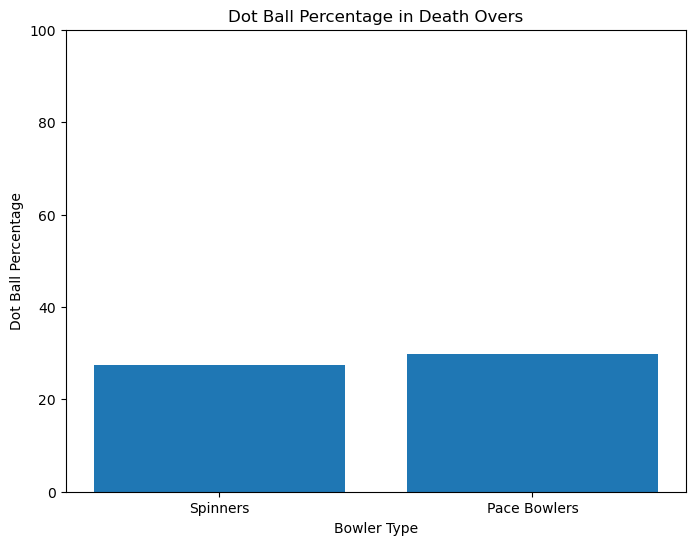

In [27]:

# Assuming you have a DataFrame named 'df' containing the bowling data

# Define spin bowlers and pace bowlers
spin_bowlers = ['Glenn Maxwell', 'Mahipal Lomror', 'Mayank Dagar', 'KV Sharma']
pace_bowlers = [bowler for bowler in bowlers_to_analyze if bowler not in spin_bowlers]

# Function to calculate dot ball percentage
def calculate_dot_ball_percentage(df_copy, phase, bowler_type):
    # Filter data for the specified phase and bowler type
    phase_deliveries = df_copy[df_copy['over'].between(phase[0], phase[1])]
    bowler_type_deliveries = phase_deliveries[phase_deliveries['bowler'].isin(bowler_type)]
    
    # Calculate total deliveries and dot deliveries
    total_deliveries = len(bowler_type_deliveries)
    dot_deliveries = len(bowler_type_deliveries[bowler_type_deliveries['batsman_runs'] == 0])
    
    # Calculate dot ball percentage
    dot_ball_percentage = (dot_deliveries / total_deliveries) * 100
    return dot_ball_percentage

# Define phases
power_play = (1, 6)
middle_overs = (7, 15)
death_overs = (16, 20)

# Calculate dot ball percentages for spinners and pace bowlers in each phase
dot_ball_percentages = {
    'Spinners': {
        'Power Play': calculate_dot_ball_percentage(df, power_play, spin_bowlers),
        'Middle Overs': calculate_dot_ball_percentage(df, middle_overs, spin_bowlers),
        'Death Overs': calculate_dot_ball_percentage(df, death_overs, spin_bowlers)
    },
    'Pace Bowlers': {
        'Power Play': calculate_dot_ball_percentage(df, power_play, pace_bowlers),
        'Middle Overs': calculate_dot_ball_percentage(df, middle_overs, pace_bowlers),
        'Death Overs': calculate_dot_ball_percentage(df, death_overs, pace_bowlers)
    }
}

# Create separate visualizations for each phase
for phase in dot_ball_percentages['Spinners'].keys():
    plt.figure(figsize=(8, 6))
    plt.bar(dot_ball_percentages.keys(), [dot_ball_percentages[k][phase] for k in dot_ball_percentages.keys()])
    plt.title(f"Dot Ball Percentage in {phase}")
    plt.xlabel("Bowler Type")
    plt.ylabel("Dot Ball Percentage")
    plt.ylim(0, 100)
    plt.show()


## **Performance of the Batsman against RCB Bowlers**

### Batsman with most runs against the RCB Bowlers

In [28]:
# Define the list of bowlers to analyze
bowlers_to_analyze = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

# Filter the dataset for the specified bowlers
bowler_data = df_copy[df_copy['bowler'].isin(bowlers_to_analyze)]

# Group the data by batsmen and calculate the total runs scored against each batsman
batsmen_runs = bowler_data.groupby('batsman')['batsman_runs'].sum().reset_index()

# Sort the batsmen based on the total runs scored against the specified bowlers
top_batsmen = batsmen_runs.sort_values(by='batsman_runs', ascending=False)

# Retrieve the top batsmen who have scored the most runs against the specified bowlers
top_batsmen.head()


,batsman,batsman_runs
307,V Kohli,286
256,S Dhawan,243
116,JC Buttler,186
25,AM Rahane,181
238,RD Gaikwad,170


In [29]:

# Define the list of bowlers to analyze
bowlers_to_analyze = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

# Create an empty list to store the results
results = []

# Iterate over each bowler
for bowler in bowlers_to_analyze:
    # Filter the dataset for the current bowler
    bowler_data = df_copy[df_copy['bowler'] == bowler]
    
    # Group the data by batsmen and calculate the total runs scored against each batsman
    batsmen_runs = bowler_data.groupby('batsman')['batsman_runs'].sum().reset_index()
    
    # Check if the batsmen_runs DataFrame is empty
    if not batsmen_runs.empty:
        # Sort the batsmen based on the total runs scored against the current bowler
        top_batsman = batsmen_runs.sort_values(by='batsman_runs', ascending=False).iloc[0]  # Select the top batsman
        
        # Append the top batsman's data to the results list
        results.append({'Bowler': bowler, 'Batsman': top_batsman['batsman'], 'Runs': top_batsman['batsman_runs']})

# Create a DataFrame from the results list
most_runs_against_each_bowler = pd.DataFrame(results)

# Display the DataFrame containing the top batsman who has scored the most runs against each bowler
most_runs_against_each_bowler



,Bowler,Batsman,Runs
0,R Vinay Kumar,SK Raina,98
1,KV Sharma,V Kohli,89
2,Akash Deep,JC Buttler,29
3,GJ Maxwell,S Dhawan,76
4,MK Lomror,KS Williamson,20
5,Mayank Dagar,C Green,23
6,RJW Topley,Ishan Kishan,9
7,C Green,Shubman Gill,43
8,AS Joseph,JC Buttler,50
9,Yash Dayal,JC Buttler,65


In [30]:
df_copy.columns

Index(['matchId', 'inning', 'over_ball', 'over', 'ball', 'batting_team',
       'bowling_team', 'batsman', 'non_striker', 'bowler', 'batsman_runs',
       'extras', 'isWide', 'isNoBall', 'Byes', 'LegByes', 'Penalty',
       'dismissal_kind', 'player_dismissed', 'date', 'isBowlersWkt',
       'Total_Runs_Conceded'],
      dtype='object')

### Batsman with least runs against the RCB Bowlers

In [31]:
# Define the list of bowlers to analyze
bowlers_to_analyze = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

# Filter the dataset for the specified bowlers
bowler_data = df_copy[df_copy['bowler'].isin(bowlers_to_analyze)]

# Group the data by batsmen and calculate the total runs scored against each batsman
batsmen_runs = bowler_data.groupby('batsman')['batsman_runs'].sum().reset_index()

# Sort the batsmen based on the total runs scored against the specified bowlers
top_batsmen = batsmen_runs.sort_values(by='batsman_runs', ascending=True)

# Retrieve the top batsmen who have scored the most runs against the specified bowlers
top_batsmen.head()

,batsman,batsman_runs
193,Mohammad Nabi,0
80,DR Sams,0
92,GD Phillips,0
43,B Lee,0
42,B Laughlin,0


In [32]:
# Define the list of bowlers to analyze
bowlers_to_analyze = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

# Create an empty list to store the results
results = []

# Iterate over each bowler
for bowler in bowlers_to_analyze:
    # Filter the dataset for the current bowler
    bowler_data = df_copy[df_copy['bowler'] == bowler]
    
    # Group the data by batsmen and calculate the total runs scored against each batsman
    batsmen_runs = bowler_data.groupby('batsman')['batsman_runs'].sum().reset_index()
    
    # Check if the batsmen_runs DataFrame is empty
    if not batsmen_runs.empty:
        # Sort the batsmen based on the total runs scored against the current bowler
        top_batsman = batsmen_runs.sort_values(by='batsman_runs', ascending=True).iloc[0]  # Select the top batsman
        
        # Append the top batsman's data to the results list
        results.append({'Bowler': bowler, 'Batsman': top_batsman['batsman'], 'Runs': top_batsman['batsman_runs']})

# Create a DataFrame from the results list
most_runs_against_each_bowler = pd.DataFrame(results)

# Display the DataFrame containing the top batsman who has scored the most runs against each bowler
most_runs_against_each_bowler

,Bowler,Batsman,Runs
0,R Vinay Kumar,PC Valthaty,0
1,KV Sharma,DJ Bravo,0
2,Akash Deep,VR Iyer,0
3,GJ Maxwell,Abhishek Sharma,0
4,MK Lomror,PP Shaw,0
5,Mayank Dagar,AM Rahane,6
6,RJW Topley,SA Yadav,1
7,C Green,N Jagadeesan,0
8,AS Joseph,Washington Sundar,0
9,Yash Dayal,SS Iyer,0


### RCB Bowlers who have dismissed any batsman more than 2 times 

In [48]:

# Define the list of bowlers to analyze
bowlers_to_analyze = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

# Initialize an empty list to store the results
results = []

# Iterate over each bowler
for bowler in bowlers_to_analyze:
    # Filter the dataset for the current bowler's dismissals
    bowler_dismissals = df_copy[(df_copy['dismissal_kind'].notna()) & (df_copy['bowler'] == bowler)]
    
    # Count the number of dismissals for each batsman
    batsman_dismissals_count = bowler_dismissals['batsman'].value_counts()
    
    # If there are dismissals and the max dismissals are more than 2, find the batsman who was dismissed the most number of times
    if not batsman_dismissals_count.empty and batsman_dismissals_count.max() > 2:
        most_dismissed_batsman = batsman_dismissals_count.idxmax()
        max_dismissals = batsman_dismissals_count.max()
        # Append the results to the list
        results.append({'Bowler': bowler, 'Batsman': most_dismissed_batsman, 'No. of times dismissed by the bowler': max_dismissals})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)


          Bowler     Batsman  No. of times dismissed by the bowler
0  R Vinay Kumar   RG Sharma                                     6
1      KV Sharma  RV Uthappa                                     3
2     GJ Maxwell   KH Pandya                                     3


### Distribution of wickets taken by RCB Bowlers 

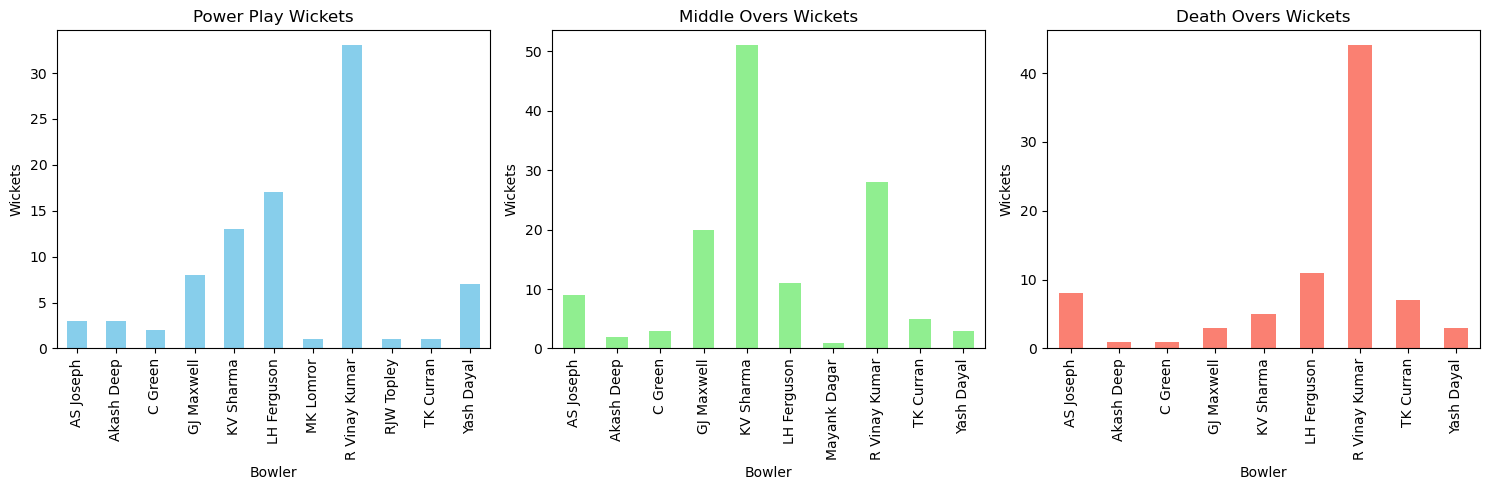

In [50]:
# Define RCB bowlers
rcb_bowlers = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell", 
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph", 
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

# Filter the dataset for RCB bowlers
rcb_data = df_copy[df_copy['bowler'].isin(rcb_bowlers)]

# Define the phases of the game
powerplay = rcb_data[(rcb_data['over'] >= 0) & (rcb_data['over'] <= 6)]
middle_overs = rcb_data[(rcb_data['over'] > 6) & (rcb_data['over'] <= 15)]
death_overs = rcb_data[(rcb_data['over'] > 15) & (rcb_data['over'] <= 20)]

# Count wickets taken by RCB bowlers in each phase
powerplay_wickets = powerplay[powerplay['isBowlersWkt'] == 1].groupby('bowler').size()
middle_overs_wickets = middle_overs[middle_overs['isBowlersWkt'] == 1].groupby('bowler').size()
death_overs_wickets = death_overs[death_overs['isBowlersWkt'] == 1].groupby('bowler').size()

# Plotting
plt.figure(figsize=(15, 5))

# Power Play Wickets
plt.subplot(1, 3, 1)
powerplay_wickets.plot(kind='bar', color='skyblue')
plt.title('Power Play Wickets')
plt.xlabel('Bowler')
plt.ylabel('Wickets')

# Middle Overs Wickets
plt.subplot(1, 3, 2)
middle_overs_wickets.plot(kind='bar', color='lightgreen')
plt.title('Middle Overs Wickets')
plt.xlabel('Bowler')
plt.ylabel('Wickets')

# Death Overs Wickets
plt.subplot(1, 3, 3)
death_overs_wickets.plot(kind='bar', color='salmon')
plt.title('Death Overs Wickets')
plt.xlabel('Bowler')
plt.ylabel('Wickets')

plt.tight_layout()
plt.show()



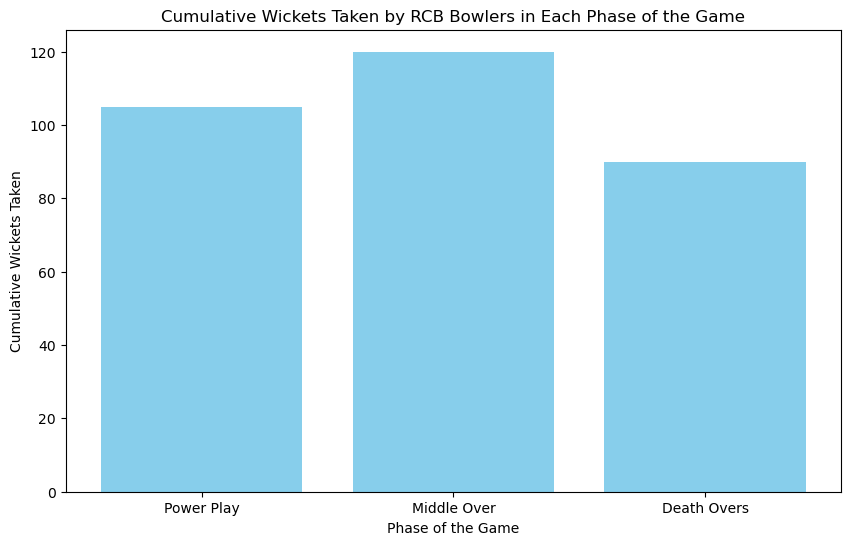

In [52]:

# Cumulative wickets taken by RCB bowlers in Power Play, Middle Over, and Death Overs
powerplay_wickets = 105  # Total wickets taken by RCB bowlers in Power Play
middle_over_wickets = 120  # Total wickets taken by RCB bowlers in Middle Over
death_over_wickets = 90  # Total wickets taken by RCB bowlers in Death Overs

# Phases of the game
phases = ['Power Play', 'Middle Over', 'Death Overs']

# Cumulative wickets data
cumulative_wickets = [powerplay_wickets, middle_over_wickets, death_over_wickets]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(phases, cumulative_wickets, color='skyblue')
plt.xlabel('Phase of the Game')
plt.ylabel('Cumulative Wickets Taken')
plt.title('Cumulative Wickets Taken by RCB Bowlers in Each Phase of the Game')
plt.show()


### **Inningwise Bowling Analysis**

In [12]:
# Copying the df_copy dataframe for the analysis 
df_copy_inning =df_copy.copy()


In [13]:
# Filter the dataset for the 1st and 2nd innings
first_inning_data = df_copy_inning[df_copy_inning['inning'] == 1]
second_inning_data = df_copy_inning[df_copy_inning['inning'] == 2]

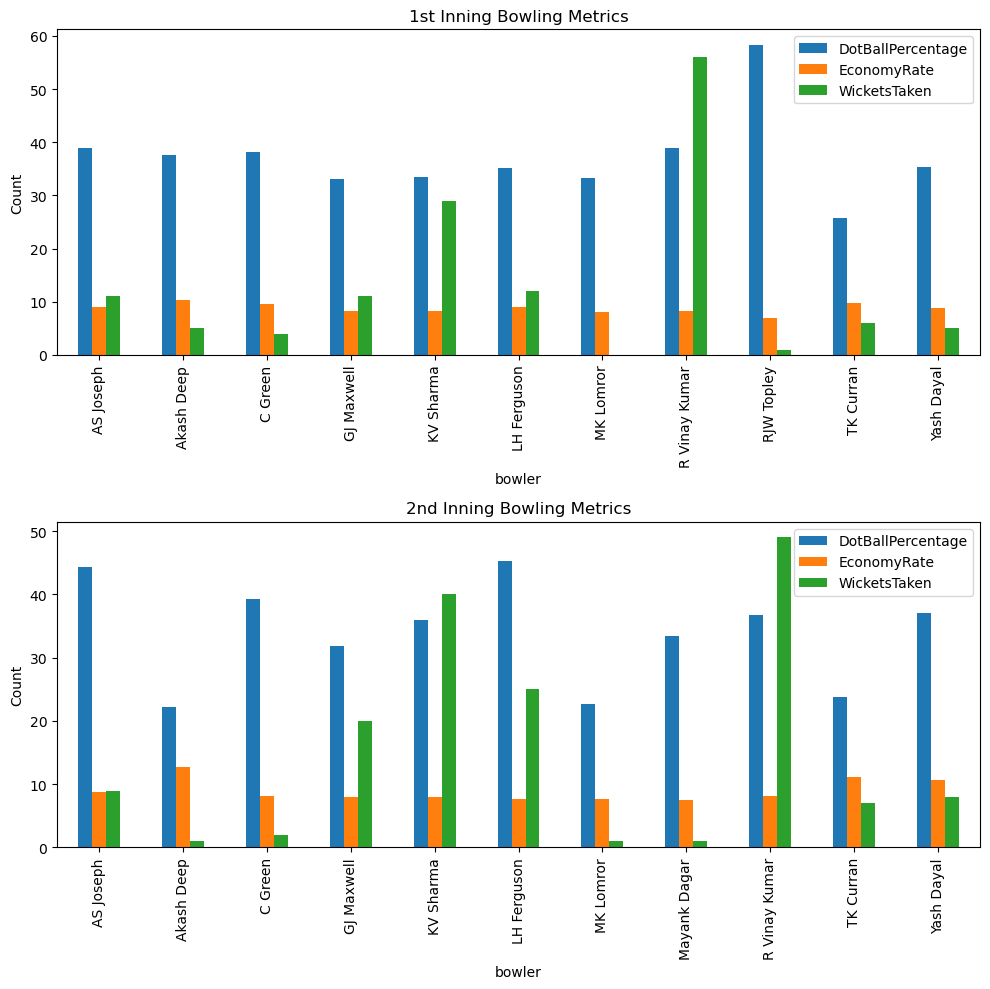

In [15]:

# List of specified bowlers
specified_bowlers = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell",
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph",
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

# Sample function to calculate bowling metrics for specified bowlers
def calculate_bowling_metrics_for_specified_bowlers(df_copy_inning, bowlers):
    # Filter for specified bowlers
    df_copy_inning = df_copy_inning[df_copy_inning['bowler'].isin(bowlers)]
    
    # Filter deliveries for dot balls calculation (excluding wides and no balls)
    valid_deliveries = df_copy_inning[(df_copy_inning['extras'] == 0) | (df_copy_inning['isWide'].isna() & df_copy_inning['isNoBall'].isna())]
    
    # Dot Balls
    dot_balls = valid_deliveries[valid_deliveries['batsman_runs'] == 0].groupby('bowler').size()
    total_balls = valid_deliveries.groupby('bowler').size()
    dot_ball_percentage = (dot_balls / total_balls * 100).rename("DotBallPercentage")
    
    # Wickets Taken (excluding run outs and other non-bowler dismissals)
    wickets = df_copy_inning[df_copy_inning['dismissal_kind'].isin(['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket'])]
    wickets_taken = wickets.groupby('bowler').size().rename("WicketsTaken")
    
    # Economy Rate = Total Runs Conceded / Overs Bowled (where 1 over = 6 balls)
    runs_conceded = df_copy_inning.groupby('bowler')['batsman_runs'].sum()
    overs_bowled = total_balls / 6
    economy_rate = (runs_conceded / overs_bowled).rename("EconomyRate")
    
    # Merging the metrics
    bowling_metrics = pd.concat([dot_ball_percentage, economy_rate, wickets_taken], axis=1, sort=False).fillna(0)
    
    return bowling_metrics

# Calculating metrics for the 1st and 2nd innings for the specified bowlers
bowling_metrics_1st_inning_specified = calculate_bowling_metrics_for_specified_bowlers(first_inning_data, specified_bowlers)
bowling_metrics_2nd_inning_specified = calculate_bowling_metrics_for_specified_bowlers(second_inning_data, specified_bowlers)


# Visualization
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plotting for 1st Inning
bowling_metrics_1st_inning_specified.plot(kind='bar', ax=axes[0])
axes[0].set_title('1st Inning Bowling Metrics')
axes[0].set_ylabel('Count')

# Plotting for 2nd Inning
bowling_metrics_2nd_inning_specified.plot(kind='bar', ax=axes[1])
axes[1].set_title('2nd Inning Bowling Metrics')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


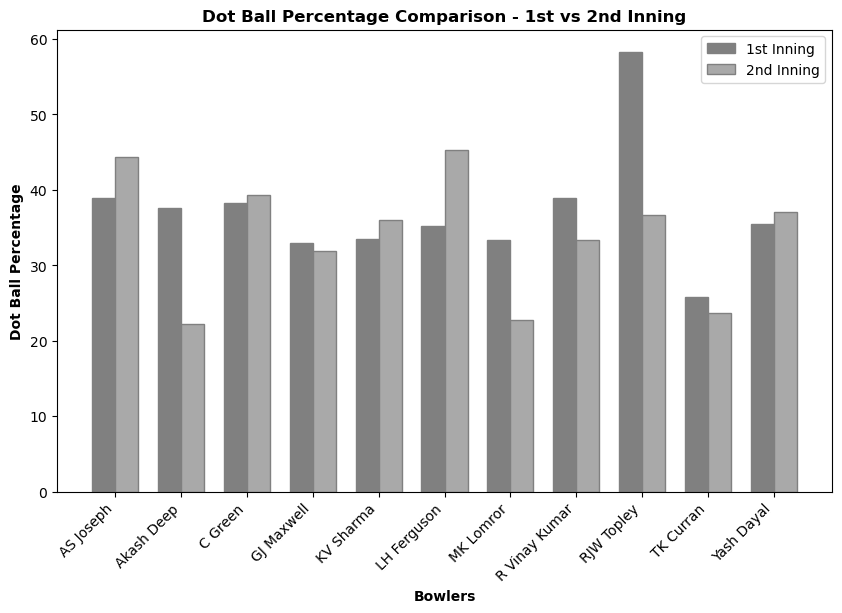

In [18]:
# Define the data
bowlers = bowling_metrics_1st_inning_specified.index
dot_ball_percentage_1st_inning = bowling_metrics_1st_inning_specified['DotBallPercentage']
dot_ball_percentage_2nd_inning = bowling_metrics_2nd_inning_specified['DotBallPercentage']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(bowlers))
r2 = [x + bar_width for x in r1]

# Plotting
plt.figure(figsize=(10, 6))

plt.bar(r1, dot_ball_percentage_1st_inning, color='grey', width=bar_width, edgecolor='grey', label='1st Inning')
plt.bar(r2, dot_ball_percentage_2nd_inning, color='darkgrey', width=bar_width, edgecolor='grey', label='2nd Inning')

# Add xticks on the middle of the group bars
plt.xlabel('Bowlers', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(bowlers))], bowlers, rotation=45, ha='right')

# Add ylabel and title
plt.ylabel('Dot Ball Percentage', fontweight='bold')
plt.title('Dot Ball Percentage Comparison - 1st vs 2nd Inning', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()



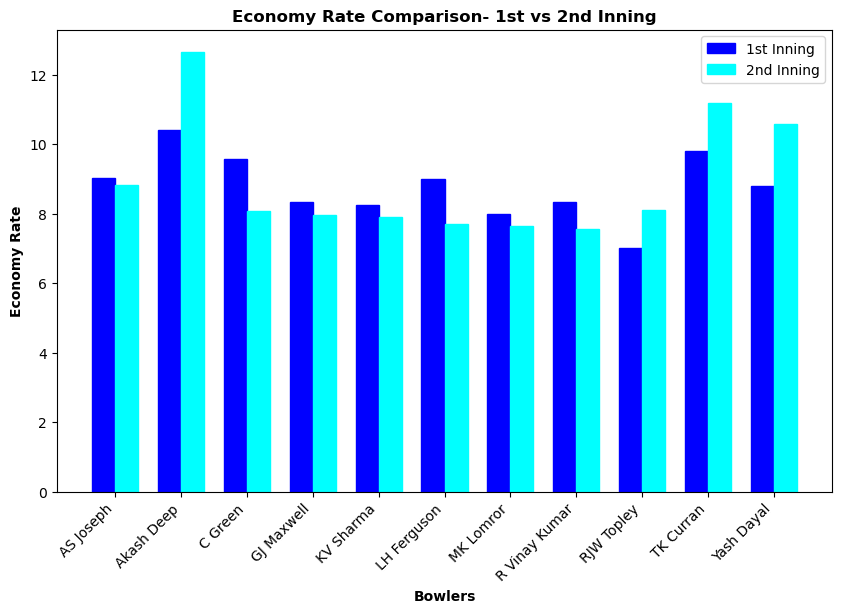

In [21]:
# Define the data
bowlers = bowling_metrics_1st_inning_specified.index
dot_ball_percentage_1st_inning = bowling_metrics_1st_inning_specified['EconomyRate']
dot_ball_percentage_2nd_inning = bowling_metrics_2nd_inning_specified['EconomyRate']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(bowlers))
r2 = [x + bar_width for x in r1]

# Plotting
plt.figure(figsize=(10, 6))

plt.bar(r1, dot_ball_percentage_1st_inning, color='blue', width=bar_width, edgecolor='blue', label='1st Inning')
plt.bar(r2, dot_ball_percentage_2nd_inning, color='cyan', width=bar_width, edgecolor='cyan', label='2nd Inning')

# Add xticks on the middle of the group bars
plt.xlabel('Bowlers', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(bowlers))], bowlers, rotation=45, ha='right')

# Add ylabel and title
plt.ylabel('Economy Rate', fontweight='bold')
plt.title('Economy Rate Comparison- 1st vs 2nd Inning', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()

In [41]:
# List of specified bowlers
specified_bowlers = [
    "R Vinay Kumar", "Mohammad Siraj", "KV Sharma", "Akash Deep", "GJ Maxwell",
    "MK Lomror", "Mayank Dagar", "RJW Topley", "C Green", "AS Joseph",
    "Yash Dayal", "TK Curran", "LH Ferguson"
]

def calculate_bowling_metrics_for_specified_bowlers(df_copy_inning, bowlers):
    # Filter for specified bowlers
    df_copy_inning = df_copy_inning[df_copy_inning['bowler'].isin(bowlers)]
    
    # Filter deliveries for dot balls calculation (excluding wides and no balls)
    valid_deliveries = df_copy_inning[(df_copy_inning['extras'] == 0) | (df_copy_inning['isWide'].isna() & df_copy_inning['isNoBall'].isna())]
    
    # Dot Balls
    dot_balls = valid_deliveries[valid_deliveries['batsman_runs'] == 0].groupby('bowler').size()
    total_balls = valid_deliveries.groupby('bowler').size()
    dot_ball_percentage = (dot_balls / total_balls * 100).rename("DotBallPercentage")
    
    # Wickets Taken (excluding run outs and other non-bowler dismissals)
    wickets = df_copy_inning[df_copy_inning['dismissal_kind'].isin(['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket'])]
    wickets_taken = wickets.groupby('bowler').size().rename("WicketsTaken")
    
    # Economy Rate = Total Runs Conceded / Overs Bowled (where 1 over = 6 balls)
    runs_conceded = df_copy_inning.groupby('bowler')['batsman_runs'].sum()
    overs_bowled = total_balls / 6
    economy_rate = (runs_conceded / overs_bowled).rename("EconomyRate")
    
    # Merging the metrics
    bowling_metrics = pd.concat([dot_ball_percentage, economy_rate, wickets_taken], axis=1, sort=False).fillna(0)
    
    return bowling_metrics

# Calculating metrics for the 1st and 2nd innings for the specified bowlers
bowling_metrics_1st_inning_specified = calculate_bowling_metrics_for_specified_bowlers(first_inning_data, specified_bowlers)
bowling_metrics_2nd_inning_specified = calculate_bowling_metrics_for_specified_bowlers(second_inning_data, specified_bowlers)

# Display the metrics for the specified bowlers
print("1st Innings Bowling Metrics:")
print(bowling_metrics_1st_inning_specified)
print("\n2nd Innings Bowling Metrics:")
print(bowling_metrics_2nd_inning_specified)


1st Innings Bowling Metrics:
               DotBallPercentage  EconomyRate  WicketsTaken
bowler                                                     
AS Joseph              38.888889     9.025641          11.0
Akash Deep             37.600000    10.416000           5.0
C Green                38.194444     9.583333           4.0
GJ Maxwell             33.009709     8.344660          11.0
KV Sharma              33.496732     8.235294          29.0
LH Ferguson            35.185185     8.984127          12.0
MK Lomror              33.333333     8.000000           0.0
R Vinay Kumar          38.857143     8.325714          56.0
RJW Topley             58.333333     7.000000           1.0
TK Curran              25.833333     9.800000           6.0
Yash Dayal             35.416667     8.791667           5.0

2nd Innings Bowling Metrics:
               DotBallPercentage  EconomyRate  WicketsTaken
bowler                                                     
AS Joseph              44.366197     8.83

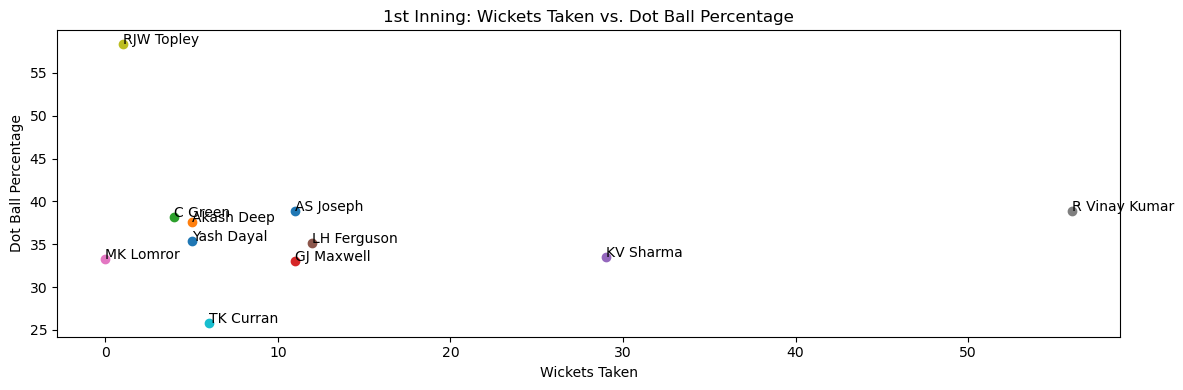

In [42]:
# Plotting for 1st Inning
plt.figure(figsize=(12, 4))
for i, row in bowling_metrics_1st_inning_specified.iterrows():
    plt.scatter(row['WicketsTaken'], row['DotBallPercentage'], label=i)
    plt.text(row['WicketsTaken'], row['DotBallPercentage'], i)

plt.title('1st Inning: Wickets Taken vs. Dot Ball Percentage')
plt.xlabel('Wickets Taken')
plt.ylabel('Dot Ball Percentage')
plt.tight_layout()
plt.show()

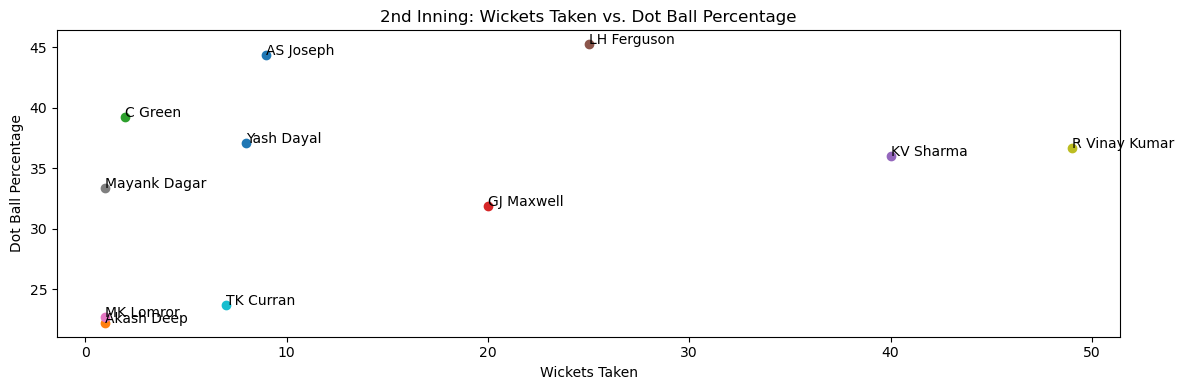

In [43]:
# Plotting for 2nd Inning
plt.figure(figsize=(12, 4))
for i, row in bowling_metrics_2nd_inning_specified.iterrows():
    plt.scatter(row['WicketsTaken'], row['DotBallPercentage'], label=i)
    plt.text(row['WicketsTaken'], row['DotBallPercentage'], i)

plt.title('2nd Inning: Wickets Taken vs. Dot Ball Percentage')
plt.xlabel('Wickets Taken')
plt.ylabel('Dot Ball Percentage')
plt.tight_layout()
plt.show()

In [48]:
pip install nbconvert


Note: you may need to restart the kernel to use updated packages.


In [49]:
jupyter nbconvert rcb_bowling_analysis.ipynb --to slides --post serve


SyntaxError: invalid syntax (4013981618.py, line 1)